# Задание Ultra pro

Сделайте классификацию цифр mnist, используя только Xtrain (без Ytrain). 

Предобучите автокодировщик. Возьмите предобученный encoder.

Нужно кластеризовать скрытое пространство, полученное из encoder (т. е. кластеризовать изображения, так как при подаче изображения на вход encoder’у получится скрытое пространство).

# Подключение библиотек

In [1]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input, Reshape, Conv2DTranspose, Activation, MaxPooling2D, Conv2D, BatchNormalization, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random

За основу данного задания будет взят ноутбук из урока - **Автокодировщики**

# Создание функций

In [2]:
# Функция создания автокодировщика

def baseAutoencoder(shape=(28,28,1), latent_dim=10): 
    
    models = {}
    # Энкодер
    img_input = Input((28,28,1))
    
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input) 
    x = BatchNormalization()(x) 
    
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = MaxPooling2D()(x)       
    
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x) 

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = MaxPooling2D()(x)       
  
    x = Flatten()(x)
    
    l = Dense(latent_dim)(x)    

    # Декодер
    z = Input( (latent_dim,) )

    x = Dense(7*7, activation='relu')(z)
    x = Reshape((7,7,1))(x)

    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 

    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x)
    x = BatchNormalization()(x) 

    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    models["encoder"] = Model(img_input, l)
    models["decoder"] = Model(z, decoded, name='Decoder')
    models["ae"] = Model(img_input, models["decoder"](models["encoder"](img_input)))

    return models

In [3]:
# Функция вывода изображения как картинок

def plotImages(xTrain, pred, shape=(112,80)):
  n = 5  # Кол-во картинок
  plt.figure(figsize=(14,7))  # Задаем фигуру и ее размер

  for i in range(n):
    index = np.random.randint(0, pred.shape[0])
    print(index)
    # Картинки из тестового набора
    ax = plt.subplot(2, n, i+1)
    plt.imshow(xTrain[index].reshape(shape))
    plt.gray()
    # Скрываем выводы координатных осей x и y. 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Восстановленные картинки
    ax = plt.subplot(2, n, i+1 + n)
    plt.imshow(pred[index].reshape(shape))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()



## NMIST

In [4]:
(xTrainMnist, yTrainMnist), (xTestMnist, yTestMnist) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [5]:
# Нормализуем данные в виде значений от 0 до 1 и меняем размерность 
xTrainMnist = xTrainMnist.astype('float32') / 255
xTrainMnist = xTrainMnist.reshape(-1, 28, 28, 1)
xTrainMnist.shape

(60000, 28, 28, 1)

## Создание сети

In [ ]:
models = baseAutoencoder()

encoder = models['encoder']
decoder = models['decoder']
model_ae = models['ae']
model_ae.compile(optimizer=Adam(learning_rate=0.001), loss="mean_squared_error")

## Модель сети

### Общая модель

In [7]:
model_ae.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model (Functional)          (None, 10)                97130     
                                                                 
 Decoder (Functional)        (None, 28, 28, 1)         102876    
                                                                 
Total params: 200,006
Trainable params: 199,046
Non-trainable params: 960
_________________________________________________________________


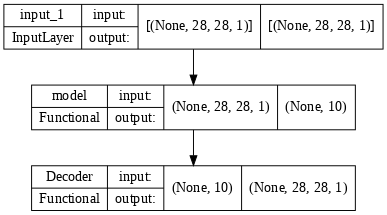

In [8]:
plot_model(model_ae, dpi=70, show_shapes=True)

### Энкодрер

In [9]:
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0     

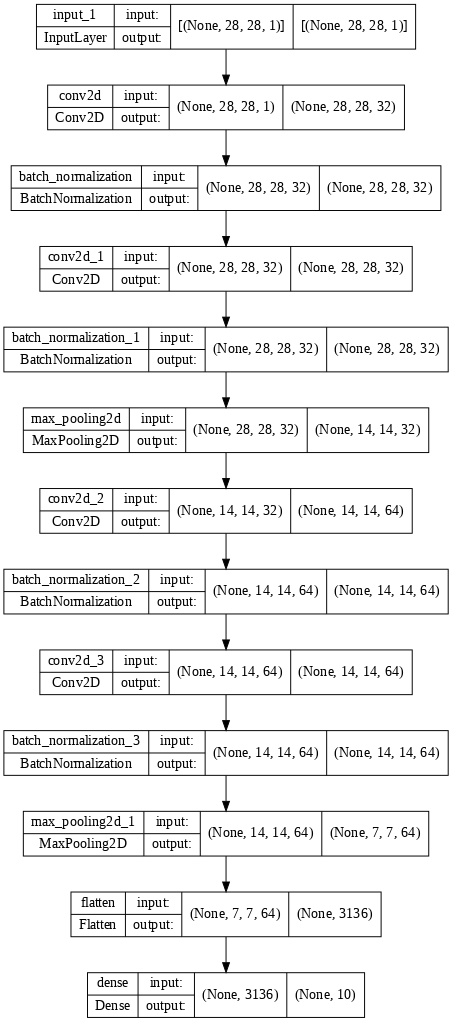

In [10]:
plot_model(encoder, dpi=70, show_shapes=True)

### Декодер

In [11]:
decoder.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_1 (Dense)             (None, 49)                539       
                                                                 
 reshape (Reshape)           (None, 7, 7, 1)           0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       320       
 nspose)                                                         
                                                                 
 batch_normalization_4 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        3692

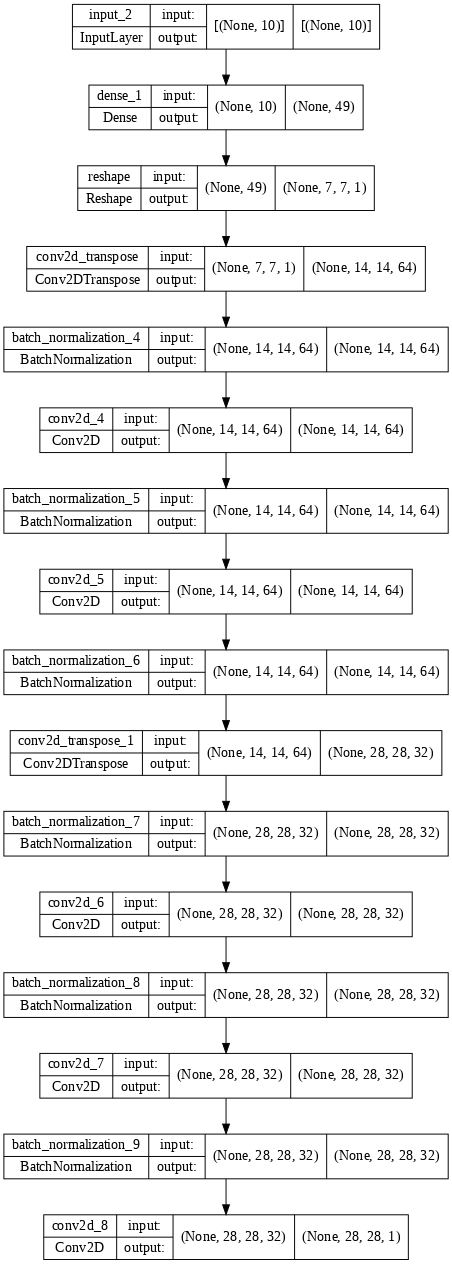

In [12]:
plot_model(decoder, dpi=70, show_shapes=True)

## Обучение сети

In [16]:
# Обучение автокодировщика
model_ae.fit(xTrainMnist, xTrainMnist, epochs=25, batch_size=128, validation_data = (xTrainMnist, xTrainMnist))

Epoch 1/25
469/469 [==============================] - 16s 34ms/step - loss: 0.0113 - val_loss: 0.0113
Epoch 2/25
469/469 [==============================] - 16s 33ms/step - loss: 0.0112 - val_loss: 0.0111
Epoch 3/25
469/469 [==============================] - 17s 37ms/step - loss: 0.0112 - val_loss: 0.0113
Epoch 4/25
469/469 [==============================] - 17s 37ms/step - loss: 0.0112 - val_loss: 0.0112
Epoch 5/25
469/469 [==============================] - 15s 33ms/step - loss: 0.0111 - val_loss: 0.0114
Epoch 6/25
469/469 [==============================] - 17s 37ms/step - loss: 0.0111 - val_loss: 0.0110
Epoch 7/25
469/469 [==============================] - 17s 37ms/step - loss: 0.0111 - val_loss: 0.0110
Epoch 8/25
469/469 [==============================] - 15s 33ms/step - loss: 0.0111 - val_loss: 0.0108
Epoch 9/25
469/469 [==============================] - 17s 37ms/step - loss: 0.0111 - val_loss: 0.0109
Epoch 10/25
469/469 [==============================] - 15s 33ms/step - loss: 0.011

In [17]:
# Сохранение весов
model_ae.save_weights('/content/model_ae-clasters.h5') # Сохраняем модель


## Предикт модели

In [ ]:
# model_ae.load_weights('/content/model_ae-clasters.h5') # Загружаем модель

In [18]:
# Получаем результат на обучающей выборке
predMnistTrain = model_ae.predict(xTrainMnist)
predMnistTrain = predMnistTrain * 255   # Перевод значений от 0 до 255
predMnistTrain = predMnistTrain.astype('uint8')

58385
18544
10233
4061
4997


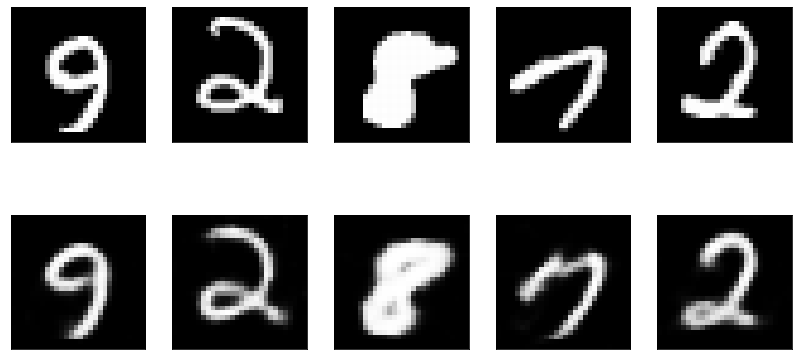

In [19]:
# Посмотрим на исходные и восстановленные картинки на обучающей выборке
plotImages(xTrainMnist, predMnistTrain, shape=(28,28))

# Кластеризация

In [22]:
# Для начала нужно получить список всех значений скрытого пространства
latent_mnist= encoder.predict(xTrainMnist)
print(latent_mnist.shape)

(60000, 10)


In [23]:
latent_mnist[0]

array([  29.512358 ,    2.0333693, -134.28563  ,  -50.27021  ,
        -10.112147 ,  -45.242233 ,   11.559066 ,    9.042339 ,
        113.042145 ,  -27.452026 ], dtype=float32)

In [24]:
# Кластеризация

# Так как цифр 10, следовательно число кластеров тоже будет 10
clustersCount = 10
kmean = KMeans(clustersCount)
kmean.fit(latent_mnist)
labels = kmean.labels_

In [25]:
print(labels[:100])

[3 4 8 7 8 2 7 2 7 0 1 3 1 6 7 5 9 2 6 0 8 4 0 7 9 9 0 1 9 0 8 2 6 5 2 3 6
 4 8 6 7 2 5 5 1 0 1 3 1 2 1 4 5 0 5 2 4 0 8 7 8 0 6 4 0 3 6 7 4 4 7 5 7 6
 1 4 9 7 7 5 1 4 4 6 5 2 1 0 4 0 6 5 8 6 2 4 5 2 1 7]


Статистика

In [26]:
# С помощью цикла посмотрим сколько элементов в каждом кластере

size_clasters = [sum(labels==i) for i in range(10)]
print(size_clasters)

[5528, 8012, 7051, 3957, 5795, 5866, 5604, 7239, 6484, 4464]


***Из данного списка видно, что кластеры примерно одинакого размера***

## Отображение результата

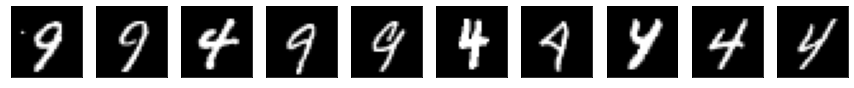

In [42]:
# Отобразим нулевой кластер
n = 10
plt.figure(figsize=(15, 5))
for i in range(n):
    index = np.random.randint(0, xTrainMnist[labels==0].shape[0])
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(xTrainMnist[labels==0][index].reshape(28,28))       
    plt.gray() 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
 

0


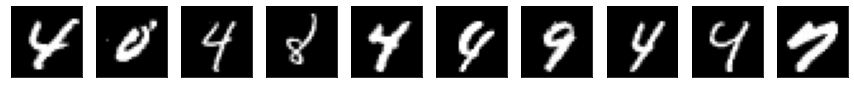

1


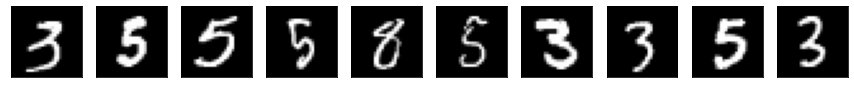

2


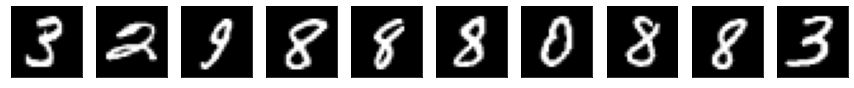

3


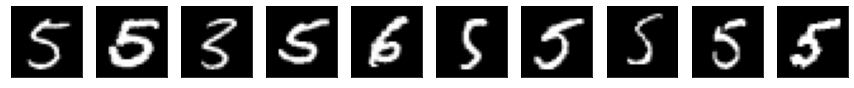

4


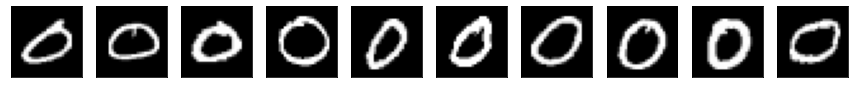

5


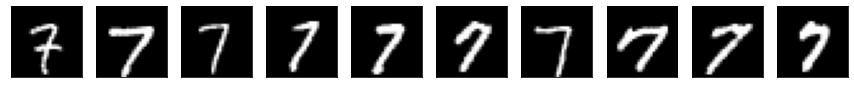

6


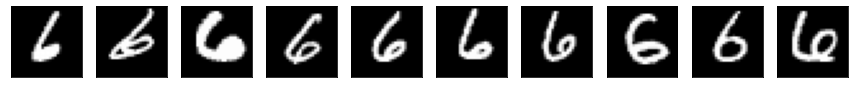

7


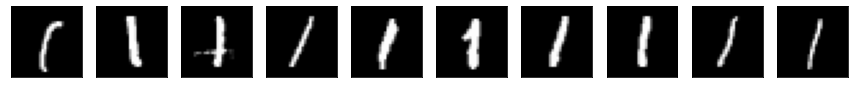

8


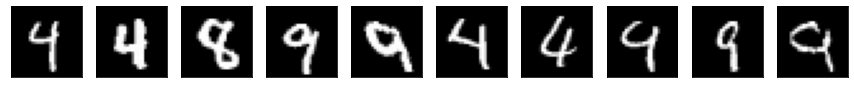

9


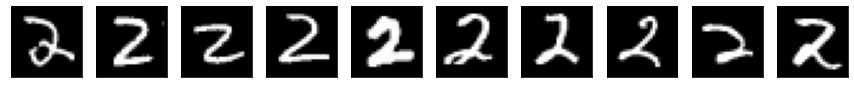

In [71]:
# С помощью двух циклов выведим все кластеры, по 10 значений в каждом

for cls in range(10):     
  plt.figure(figsize=(15, 5))
  print(cls)
  for i in range(10):
      index = np.random.randint(0, xTrainMnist[labels== cls].shape[0])
      ax = plt.subplot(2, 10, i + 1)
      plt.imshow(xTrainMnist[labels== cls][index].reshape(28,28))       
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()


# Выводы:

1. Как видно из отображения кластеризация справилось со задачей.
2. Есть кластеры где нет ошибок, такие как номера кластеров **3,4,5,6,7,9**
3. В некоторых кластерах появляются ошибки. Из-за схожести цифр такие как **3,5** и **8** или **8,2** или **9,4**.
4. Для улучшения кластеризация можно попробовать изменить размерность скрытого пространства, улучшение архитектуры нейронной сети, подбор гиперпараметров. А так же увеличение обучающей выборки.